In [1]:
from fbprophet import Prophet
import fbprophet.diagnostics as Prophet_Diagnostics

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from datetime import datetime
import warnings
import scipy.stats as stats
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Reading data

In [2]:
# reading data
evo_data = pd.read_csv('data/demand_datasets/evo_demand.csv', index_col=0)
modo_data = pd.read_csv('data/demand_datasets/modo_demand.csv', index_col=0)
c2g_data = pd.read_csv('data/demand_datasets/c2g_demand.csv', index_col=0)

In [3]:
#cleaning process
evo_data.index = pd.to_datetime(evo_data.index)
modo_data.index = pd.to_datetime(modo_data.index)
c2g_data.index = pd.to_datetime(c2g_data.index)

In [4]:
init_period = '06-23'
end_period = '07-12'

evo_data = evo_data[(evo_data.index >= '2018-'+init_period) & (evo_data.index <= '2018-'+end_period)]
modo_data = modo_data[(modo_data.index >= '2018-'+init_period) & (modo_data.index <= '2018-'+end_period)]
c2g_data = c2g_data[(c2g_data.index >= '2017-'+init_period) & (c2g_data.index <= '2017-'+end_period)]

In [5]:
def to_prophet_data(data):
    """
        Convert a time series list to the prophet data structure
    """
    prophet_data = pd.DataFrame(list(zip(data.index, data.travels)), columns=['ds','y'])
    prophet_data.sort_values(by='ds',inplace=True)
    prophet_data.reset_index(inplace=True, drop=True)
    
    return prophet_data

In [6]:
#prophet data structure

evo_prophet = to_prophet_data(evo_data)
modo_prophet = to_prophet_data(modo_data)
c2g_prophet = to_prophet_data(c2g_data)

## Train data used

In [7]:
def plot_time_points(data):
    fig, ax = plt.subplots(1,1)
    
    ax.scatter(data.ds, data.y, alpha=0.3)

    ax.set_xlim(data.ds.min(), data.ds.max())
    plt.xticks(rotation=45)
    
    plt.show()

### EVO

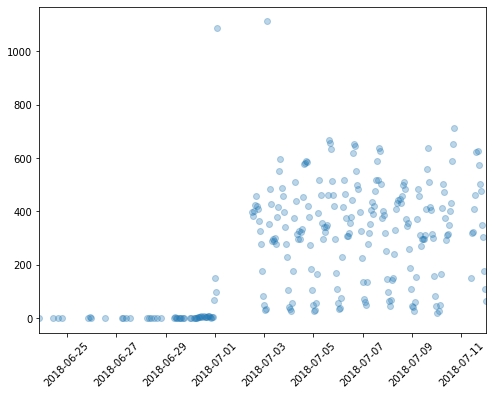

In [8]:
plot_time_points(evo_prophet)

### Modo

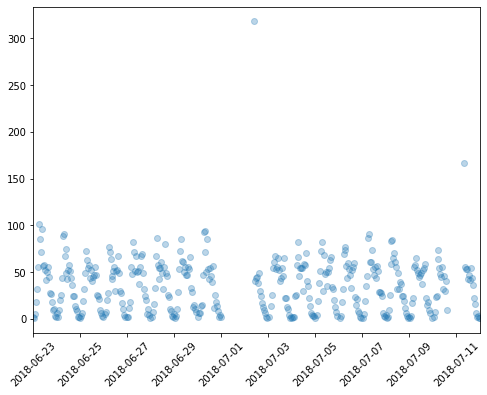

In [9]:
plot_time_points(modo_prophet)

### Car2Go

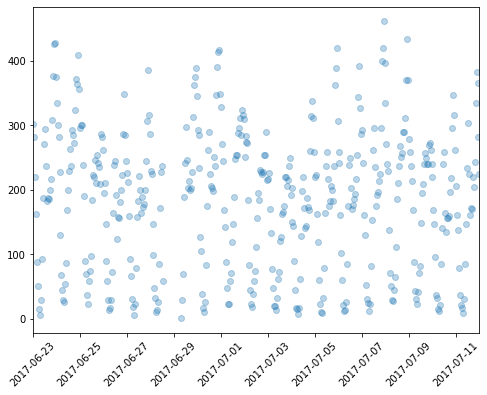

In [10]:
plot_time_points(c2g_prophet)

## Normalizing Datasets

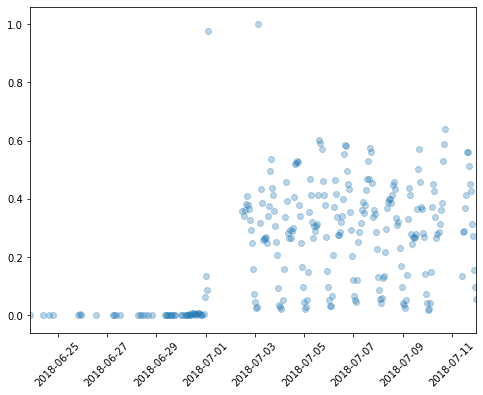

In [11]:
evo_z_scores = stats.zscore(evo_prophet.y)
abs_evo_z_scores = np.abs(evo_z_scores)
filtered_evo_entries = (abs_evo_z_scores < 4)
evo_filtered_prophet = evo_prophet[filtered_evo_entries]
v_min = evo_filtered_prophet.y.min()
v_max = evo_filtered_prophet.y.max()
evo_filtered_prophet.y -= v_min
evo_filtered_prophet.y /= (v_max - v_min)
plot_time_points(evo_filtered_prophet)

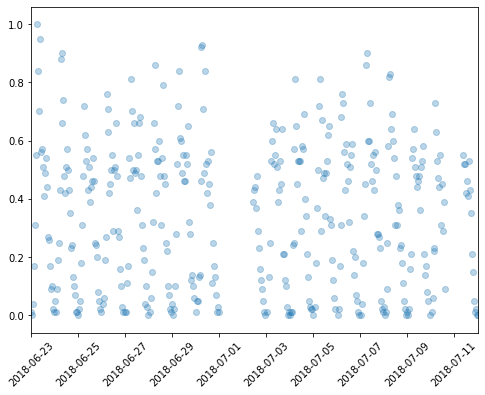

In [12]:
modo_z_scores = stats.zscore(modo_prophet.y)
abs_modo_z_scores = np.abs(modo_z_scores)
filtered_modo_entries = (abs_modo_z_scores < 4)
modo_filtered_prophet = modo_prophet[filtered_modo_entries]
v_min = modo_filtered_prophet.y.min()
v_max = modo_filtered_prophet.y.max()
modo_filtered_prophet.y -= v_min
modo_filtered_prophet.y /= (v_max - v_min)
plot_time_points(modo_filtered_prophet)

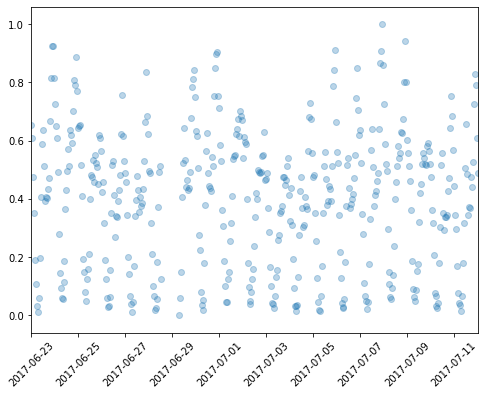

In [13]:
c2g_z_scores = stats.zscore(c2g_prophet.y)
abs_c2g_z_scores = np.abs(c2g_z_scores)
filtered_c2g_entries = (abs_c2g_z_scores < 4)
c2g_filtered_prophet = c2g_prophet[filtered_c2g_entries]
v_min = c2g_filtered_prophet.y.min()
v_max = c2g_filtered_prophet.y.max()
c2g_filtered_prophet.y -= v_min
c2g_filtered_prophet.y /= (v_max - v_min)
plot_time_points(c2g_filtered_prophet)

Now I will test the reduction in size the filtering causes

In [14]:
print("Evo: ", 100 - (len(evo_filtered_prophet)/len(evo_prophet)*100),"%")
print("Modo: ", 100 - (len(modo_filtered_prophet)/len(modo_prophet)*100),"%")
print("Car2Go: ", 100 - (len(c2g_filtered_prophet)/len(c2g_prophet)*100),"%")

Evo:  0.0 %
Modo:  0.5050505050505052 %
Car2Go:  0.0 %


## Prophet forecast

In [15]:
holidays = pd.DataFrame({
  'holiday': 'Canada_day',
  'ds': pd.to_datetime(['2017-07-01','2018-07-02']),
  'lower_window': 0,
  'upper_window': 1,
})

In [16]:
plot_styling = {
    "legend_font_size":32,
    "axis_value_size":32,
    "axis_label_size":34
}

In [17]:
def prophet_predict(data, holidays, freq='min', periods=5):
    model = Prophet(weekly_seasonality=True, yearly_seasonality=False, holidays=holidays)
    model.fit(data)
    
    future = model.make_future_dataframe(freq=freq, periods=periods)
    
    forecast = model.predict(future)
    
    return model, forecast

In [18]:
def plot_forecast(df, df_forecast, predict_period, savefile='', legend_font_size="medium",
                                    axis_value_size="medium", axis_label_size="medium"):

    plt.figure(figsize=(30,10))
    plt.scatter(df.ds,df.y,c='black',s=8,label='Valores Reais')
    plt.plot(df_forecast.ds[:-predict_period], df_forecast.yhat[:-60*12], label='Valores Preditos')
    plt.fill_between(df_forecast.ds,df_forecast.yhat_upper,df_forecast.yhat_lower,
                     label='Intervalo de Incerteza',alpha=0.3)
    plt.plot(df_forecast.ds[-predict_period:], df_forecast.yhat[-60*12:], label='Valores Preditos Futuros',ls='--')

    plt.xlim(df_forecast.ds.min(), df_forecast.ds.max())
    plt.ylabel('Viagens requisitadas por hora', fontdict={"fontsize":axis_label_size})
    plt.xlabel('Horas', fontdict={"fontsize":axis_label_size})
    plt.legend(fontsize=legend_font_size, loc=1, borderaxespad=0.2, frameon=False)
    plt.tick_params(axis="both", labelsize=axis_value_size)
    plt.xticks(rotation=45)
    
    ax = plt.gca()
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    if savefile != '':
        plt.savefig(savefile, bbox_inches='tight')

    plt.show()

In [19]:
PREDICT_PERIOD = 60*12  # 12 hours
evo_model, evo_forecast = prophet_predict(evo_prophet, periods=PREDICT_PERIOD, holidays=holidays)
print('EVO done.')
modo_model, modo_forecast = prophet_predict(modo_prophet, periods=PREDICT_PERIOD, holidays=holidays)
print('Modo done.')
c2g_model, c2g_forecast = prophet_predict(c2g_prophet, periods=PREDICT_PERIOD, holidays=holidays)
print('Car2Go done.')

EVO done.
Modo done.
Car2Go done.


In [20]:
evo_filtered_model, evo_filtered_forecast = prophet_predict(evo_filtered_prophet, periods=PREDICT_PERIOD, holidays=holidays)
print('EVO filtered done.')
modo_filtered_model, modo_filtered_forecast = prophet_predict(modo_filtered_prophet, periods=PREDICT_PERIOD, holidays=holidays)
print('Modo filtered done.')
c2g_filtered_model, c2g_filtered_forecast = prophet_predict(c2g_filtered_prophet, periods=PREDICT_PERIOD, holidays=holidays)
print('Car2Go filtered done.')

EVO filtered done.
Modo filtered done.
Car2Go filtered done.


### EVO

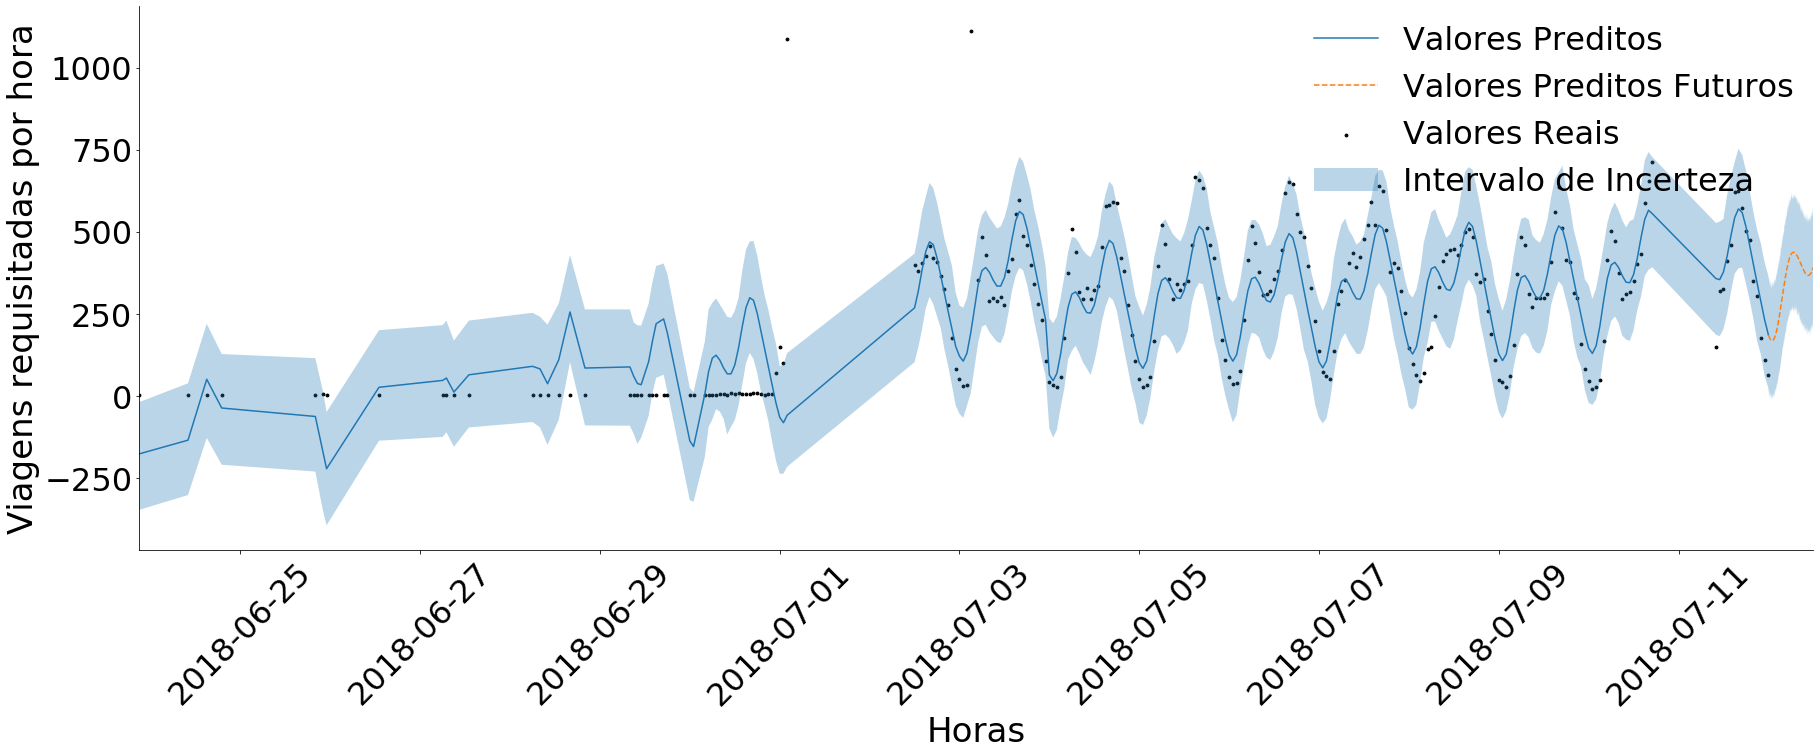

In [21]:
plot_forecast(evo_prophet,evo_forecast,PREDICT_PERIOD, **plot_styling)

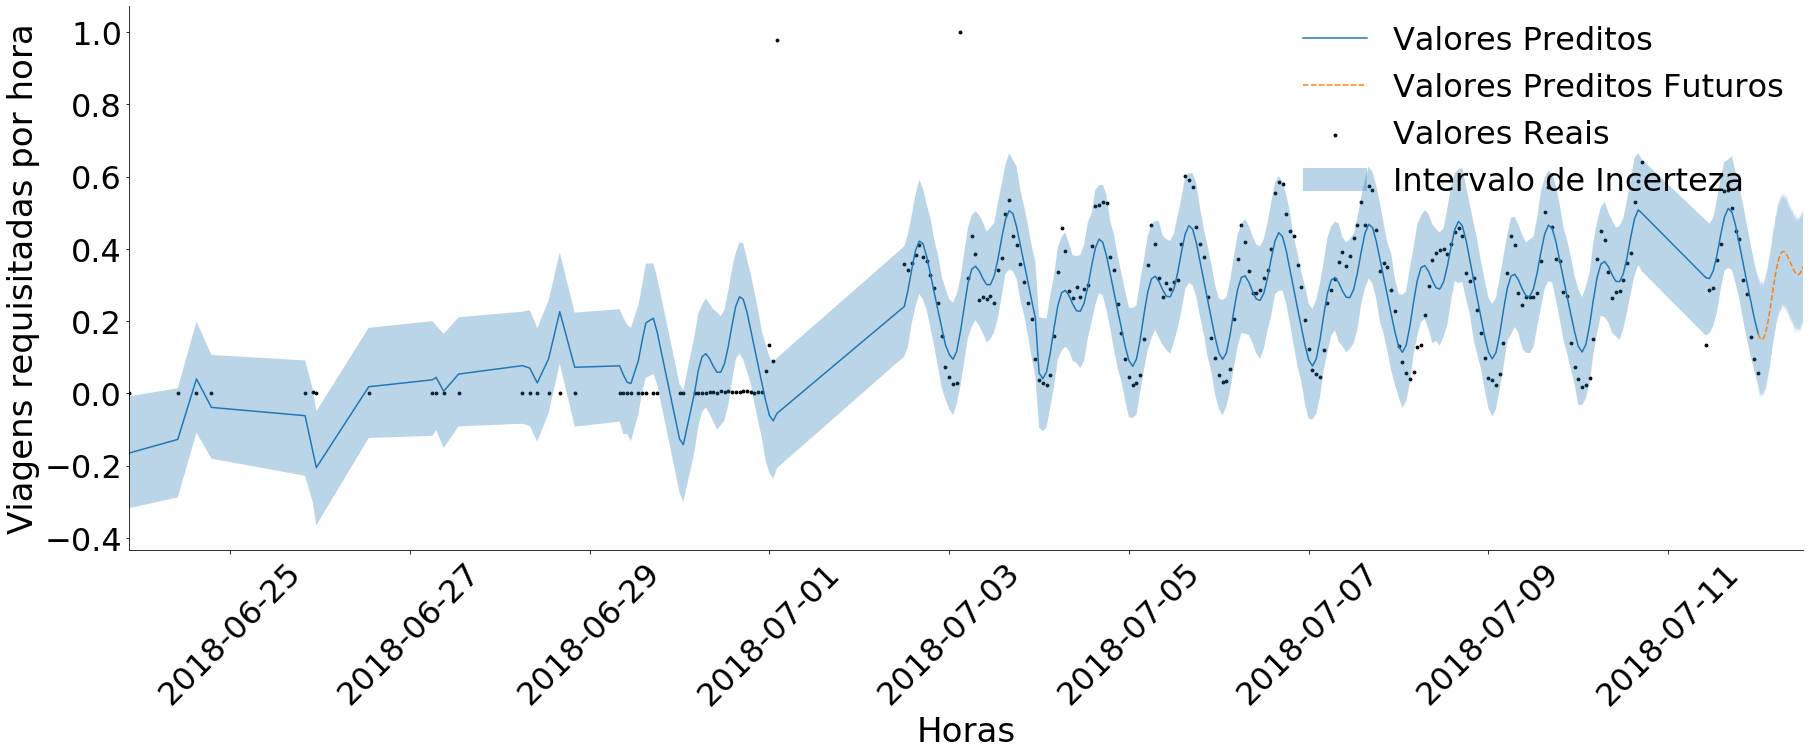

In [23]:
plot_forecast(evo_filtered_prophet,evo_filtered_forecast,PREDICT_PERIOD,'images/prophet/evo.png', **plot_styling)

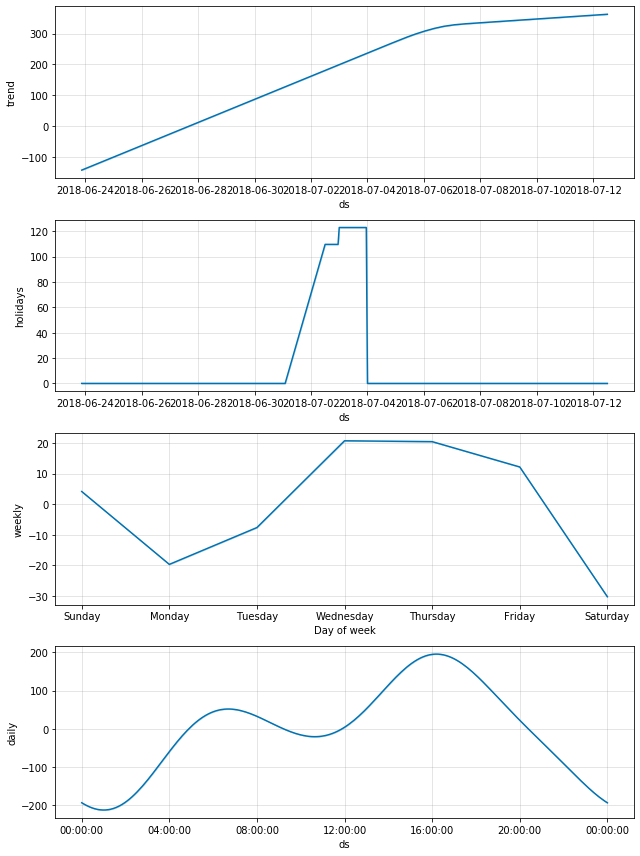

In [24]:
fig1 = evo_model.plot_components(evo_forecast)
plt.show()

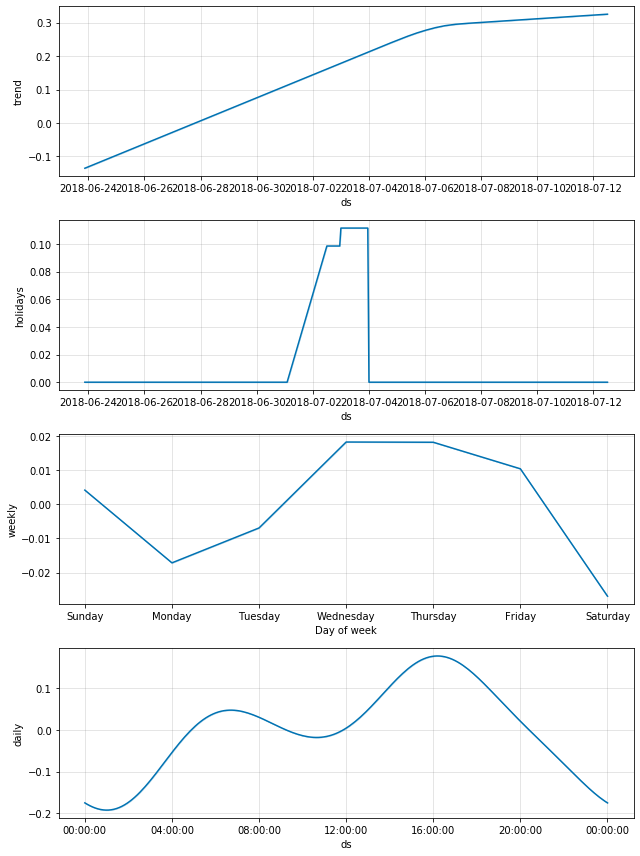

In [25]:
fig1 = evo_filtered_model.plot_components(evo_filtered_forecast)
plt.savefig('images/prophet/evo_trend.png', bbox_inches='tight')
plt.show()

In [42]:
cv_filtered_results_evo = Prophet_Diagnostics.cross_validation(evo_filtered_model,horizon="12 hours", period="1 hour")
Prophet_Diagnostics.performance_metrics(cv_filtered_results_evo,rolling_window=1)

INFO:fbprophet:Making 213 forecasts with cutoffs between 2018-07-02 00:00:00 and 2018-07-11 12:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,12:00:00,0.04326,0.207991,0.167807,1.621746,0.441337,0.549337


### Modo

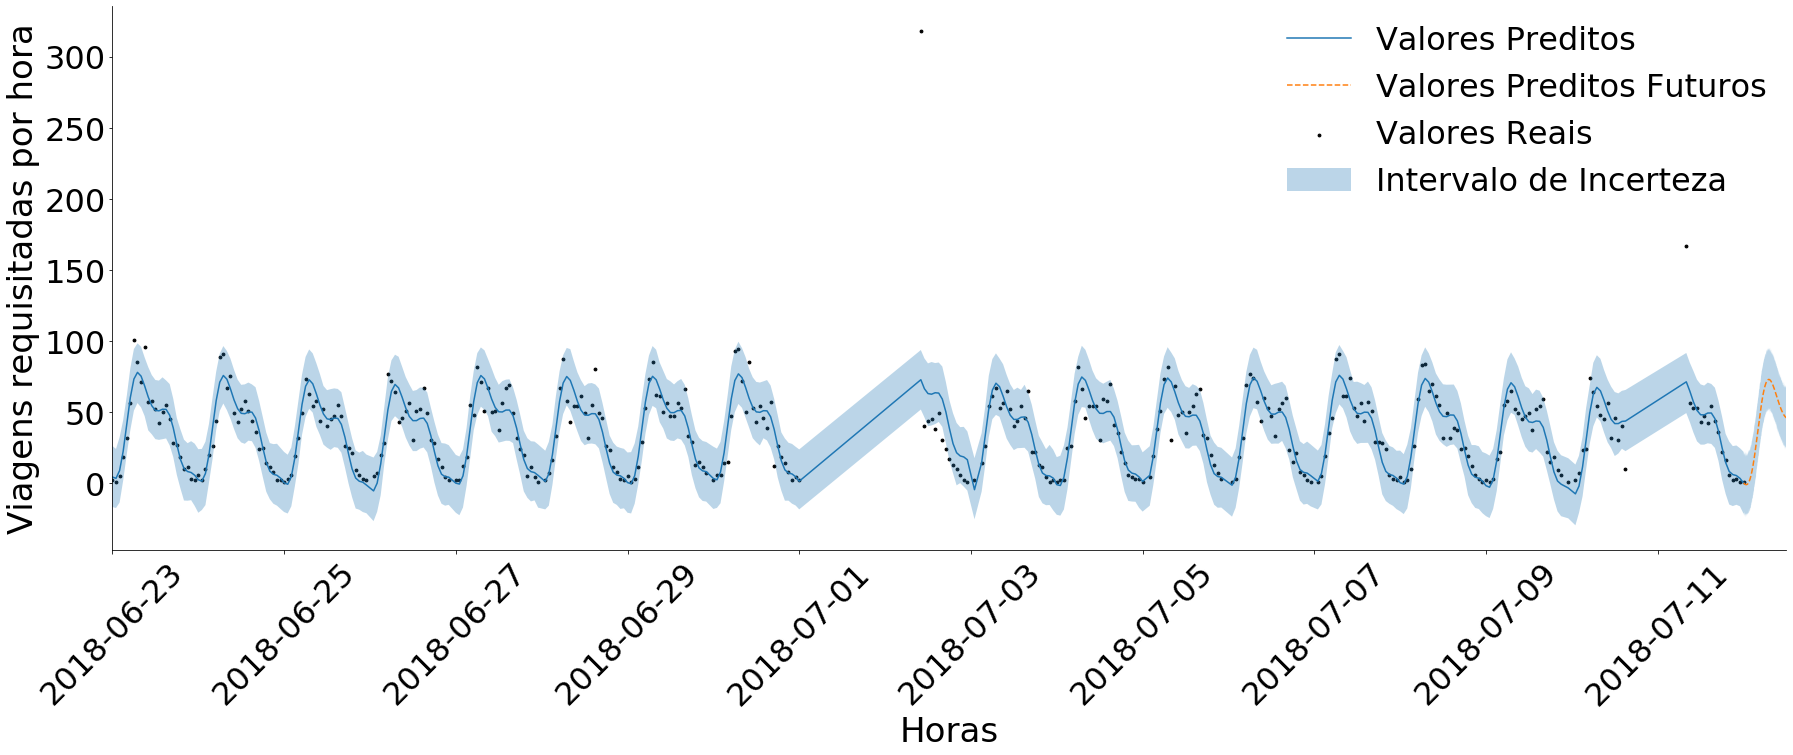

In [27]:
plot_forecast(modo_prophet,modo_forecast,PREDICT_PERIOD, **plot_styling)

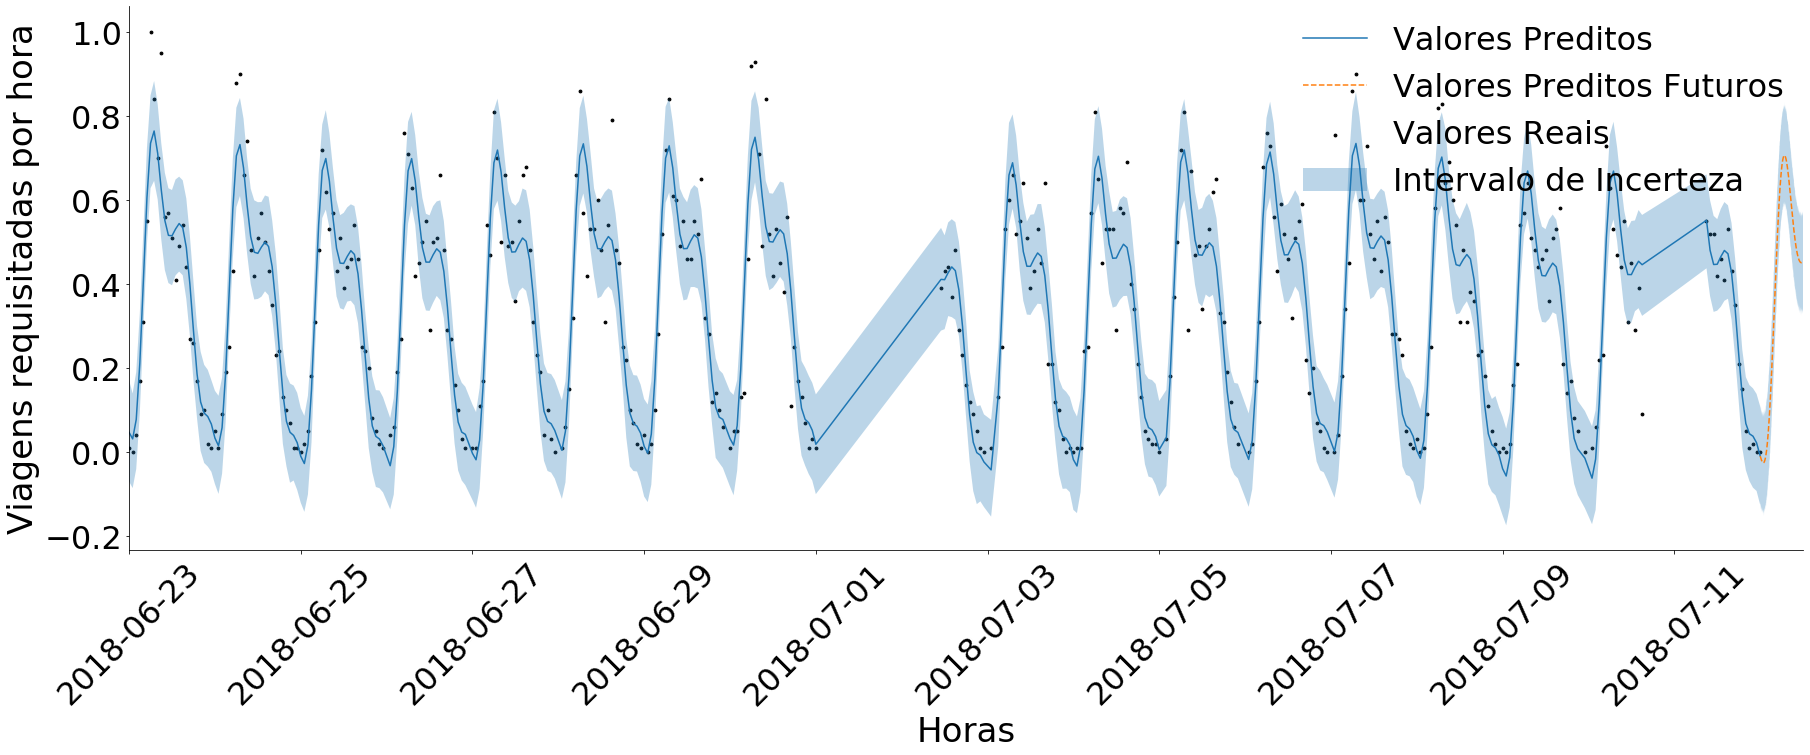

In [28]:
plot_forecast(modo_filtered_prophet,modo_filtered_forecast,PREDICT_PERIOD,'images/prophet/modo.png', **plot_styling)

In [29]:
evo_filtered_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Canada_day,Canada_day_lower,Canada_day_upper,additive_terms,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-06-23 21:00:00,-0.135178,-0.317702,-0.008008,-0.135178,-0.135178,0.0,0.0,0.0,-0.029991,...,0.0,0.0,0.0,0.000943,0.000943,0.000943,0.0,0.0,0.0,-0.165169
1,2018-06-24 10:00:00,-0.116536,-0.287999,0.014060,-0.116536,-0.116536,0.0,0.0,0.0,-0.010751,...,0.0,0.0,0.0,0.003517,0.003517,0.003517,0.0,0.0,0.0,-0.127287
2,2018-06-24 15:00:00,-0.109367,-0.108920,0.198776,-0.109367,-0.109367,0.0,0.0,0.0,0.149507,...,0.0,0.0,0.0,-0.002785,-0.002785,-0.002785,0.0,0.0,0.0,0.040140
3,2018-06-24 19:00:00,-0.103631,-0.180690,0.106508,-0.103631,-0.103631,0.0,0.0,0.0,0.064836,...,0.0,0.0,0.0,-0.009257,-0.009257,-0.009257,0.0,0.0,0.0,-0.038795
4,2018-06-25 20:00:00,-0.067782,-0.228118,0.091219,-0.067782,-0.067782,0.0,0.0,0.0,0.006099,...,0.0,0.0,0.0,-0.014165,-0.014165,-0.014165,0.0,0.0,0.0,-0.061683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,2018-07-12 11:56:00,0.325396,0.187339,0.507150,0.325200,0.325628,0.0,0.0,0.0,0.023943,...,0.0,0.0,0.0,0.022332,0.022332,0.022332,0.0,0.0,0.0,0.349339
980,2018-07-12 11:57:00,0.325400,0.199628,0.499297,0.325203,0.325633,0.0,0.0,0.0,0.024471,...,0.0,0.0,0.0,0.022330,0.022330,0.022330,0.0,0.0,0.0,0.349871
981,2018-07-12 11:58:00,0.325404,0.195459,0.505595,0.325206,0.325637,0.0,0.0,0.0,0.025006,...,0.0,0.0,0.0,0.022327,0.022327,0.022327,0.0,0.0,0.0,0.350409
982,2018-07-12 11:59:00,0.325408,0.197692,0.496202,0.325209,0.325642,0.0,0.0,0.0,0.025547,...,0.0,0.0,0.0,0.022325,0.022325,0.022325,0.0,0.0,0.0,0.350955


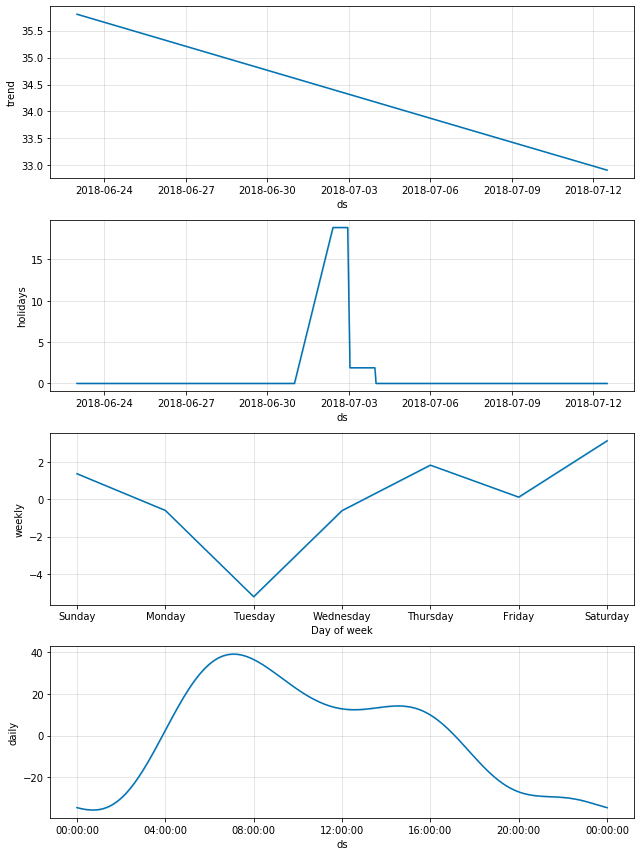

In [30]:
fig1 = modo_model.plot_components(modo_forecast)
plt.savefig('images/prophet/modo_trend.png', bbox_inches='tight')
plt.show()

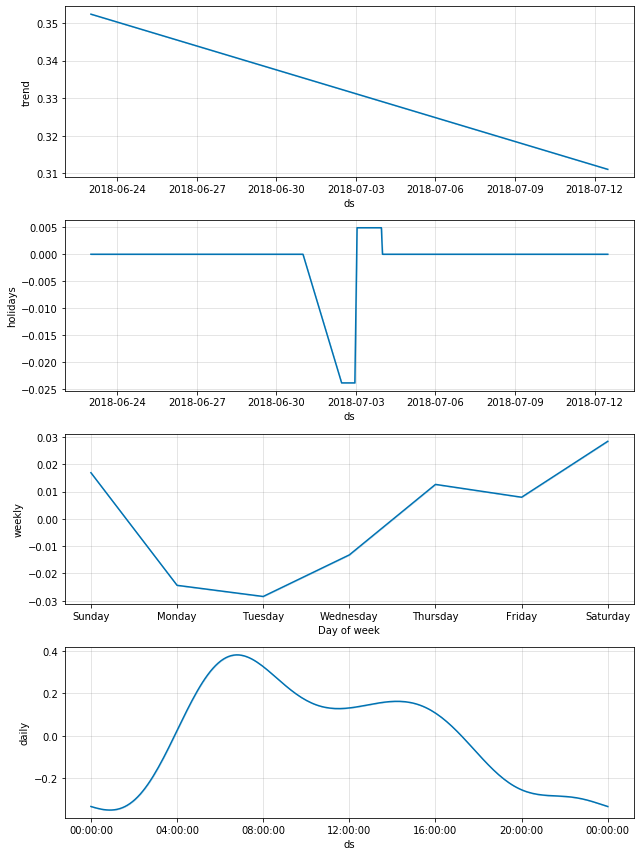

In [31]:
fig1 = modo_filtered_model.plot_components(modo_filtered_forecast)
plt.show()

In [40]:
cv_filtered_results_modo = Prophet_Diagnostics.cross_validation(modo_filtered_model,horizon="12 hours", period="1 hour")
Prophet_Diagnostics.performance_metrics(cv_filtered_results_modo,rolling_window=1)

INFO:fbprophet:Making 226 forecasts with cutoffs between 2018-06-30 00:00:00 and 2018-07-11 12:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,12:00:00,0.008499,0.09219,0.0679,0.209451,0.813205


### Car2Go

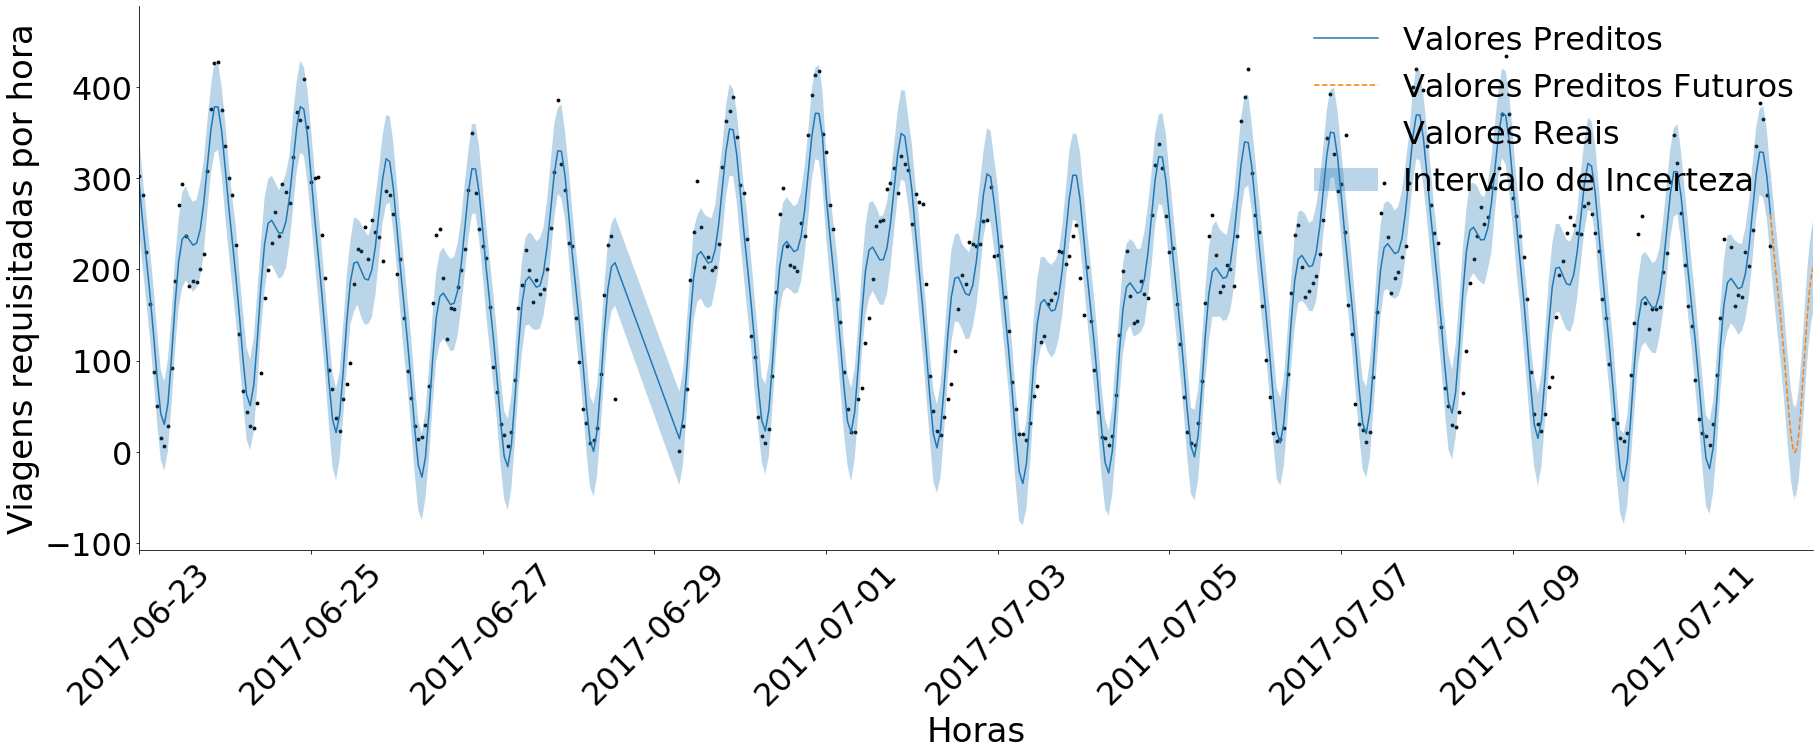

In [33]:
plot_forecast(c2g_prophet,c2g_forecast,PREDICT_PERIOD, **plot_styling)

In [34]:
c2g_filtered_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Canada_day,Canada_day_lower,Canada_day_upper,additive_terms,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-06-23 00:00:00,0.421685,0.518121,0.742656,0.421685,0.421685,0.0,0.0,0.0,0.210946,...,0.0,0.0,0.0,0.027929,0.027929,0.027929,0.0,0.0,0.0,0.632630
1,2017-06-23 01:00:00,0.421593,0.436264,0.649305,0.421593,0.421593,0.0,0.0,0.0,0.117321,...,0.0,0.0,0.0,0.028839,0.028839,0.028839,0.0,0.0,0.0,0.538914
2,2017-06-23 02:00:00,0.421501,0.355024,0.568278,0.421501,0.421501,0.0,0.0,0.0,0.032732,...,0.0,0.0,0.0,0.029822,0.029822,0.029822,0.0,0.0,0.0,0.454233
3,2017-06-23 03:00:00,0.421408,0.263197,0.482017,0.421408,0.421408,0.0,0.0,0.0,-0.050758,...,0.0,0.0,0.0,0.030887,0.030887,0.030887,0.0,0.0,0.0,0.370651
4,2017-06-23 04:00:00,0.421316,0.164372,0.377061,0.421316,0.421316,0.0,0.0,0.0,-0.146217,...,0.0,0.0,0.0,0.032039,0.032039,0.032039,0.0,0.0,0.0,0.275100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,2017-07-12 11:56:00,0.411718,0.338077,0.546813,0.411684,0.411767,0.0,0.0,0.0,0.026987,...,0.0,0.0,0.0,-0.009925,-0.009925,-0.009925,0.0,0.0,0.0,0.438706
1156,2017-07-12 11:57:00,0.411720,0.333218,0.551452,0.411685,0.411769,0.0,0.0,0.0,0.027504,...,0.0,0.0,0.0,-0.009901,-0.009901,-0.009901,0.0,0.0,0.0,0.439224
1157,2017-07-12 11:58:00,0.411721,0.321801,0.541172,0.411687,0.411771,0.0,0.0,0.0,0.028009,...,0.0,0.0,0.0,-0.009876,-0.009876,-0.009876,0.0,0.0,0.0,0.439730
1158,2017-07-12 11:59:00,0.411723,0.334162,0.543614,0.411688,0.411772,0.0,0.0,0.0,0.028501,...,0.0,0.0,0.0,-0.009852,-0.009852,-0.009852,0.0,0.0,0.0,0.440224


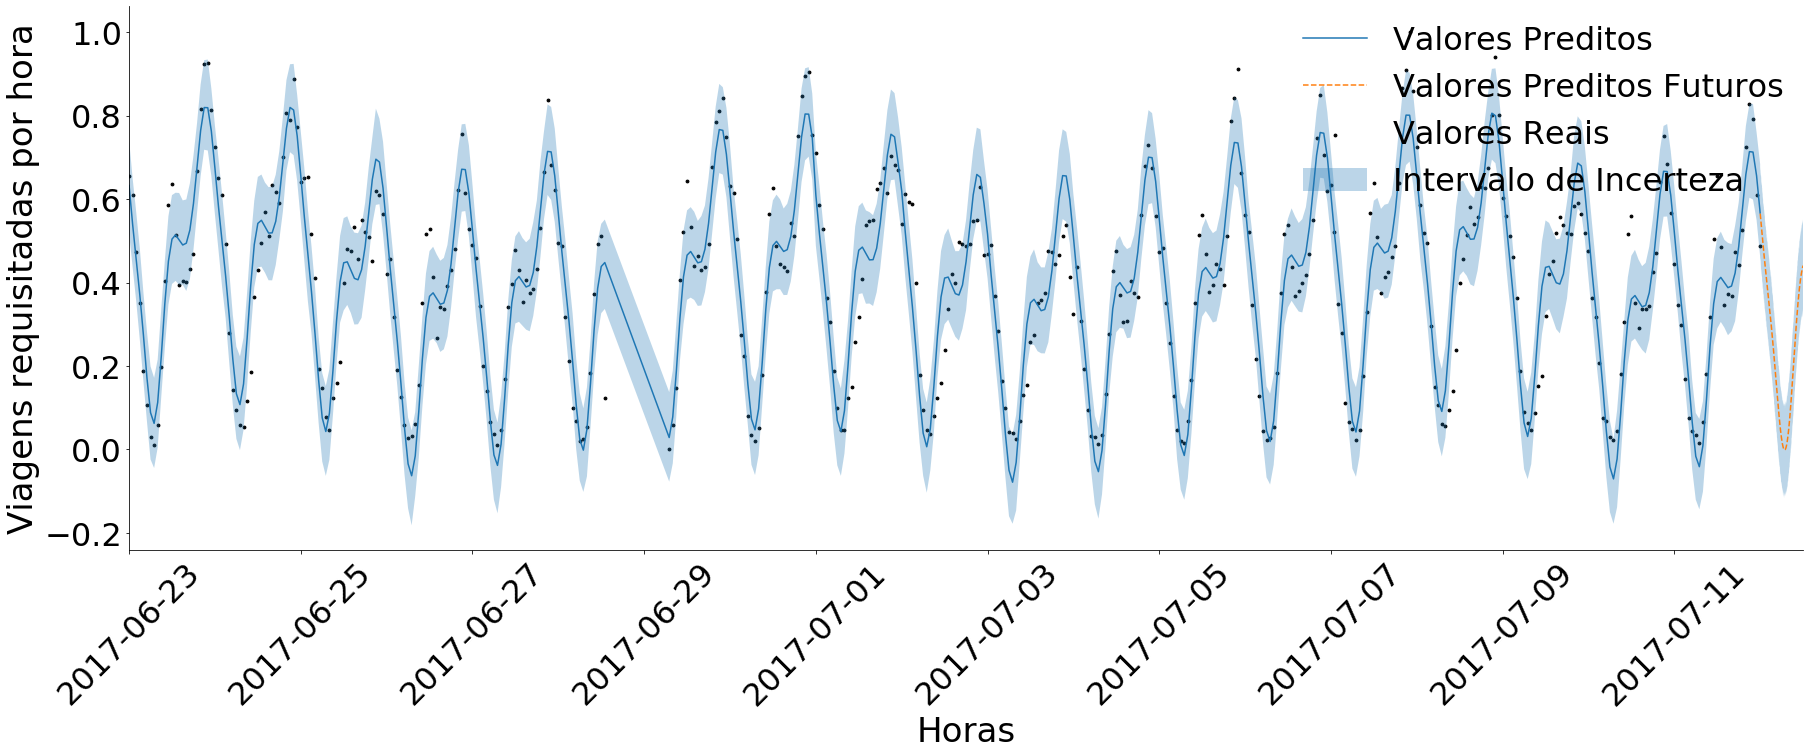

In [35]:
plot_forecast(c2g_filtered_prophet,c2g_filtered_forecast,PREDICT_PERIOD,'images/prophet/c2g.png', **plot_styling)

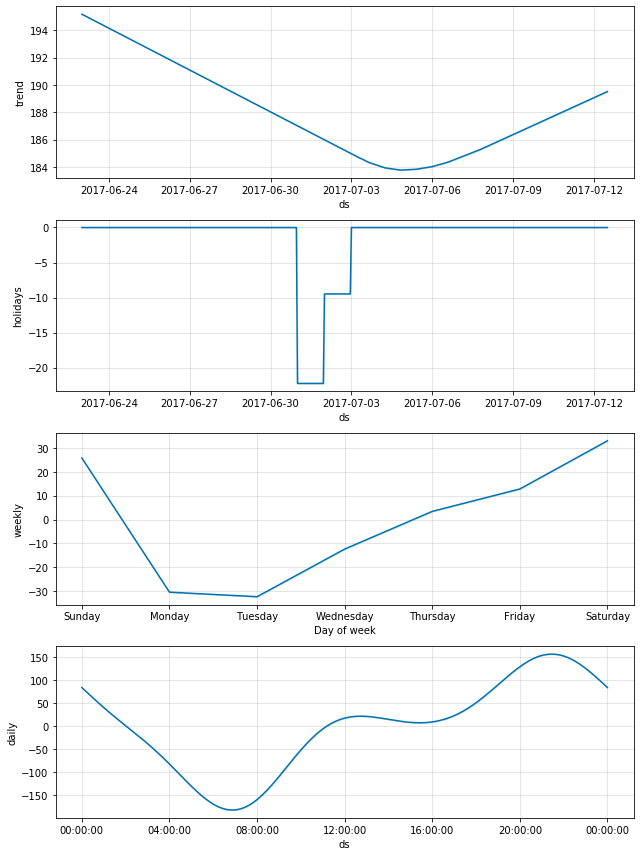

In [36]:
fig1 = c2g_model.plot_components(c2g_forecast)
plt.show()

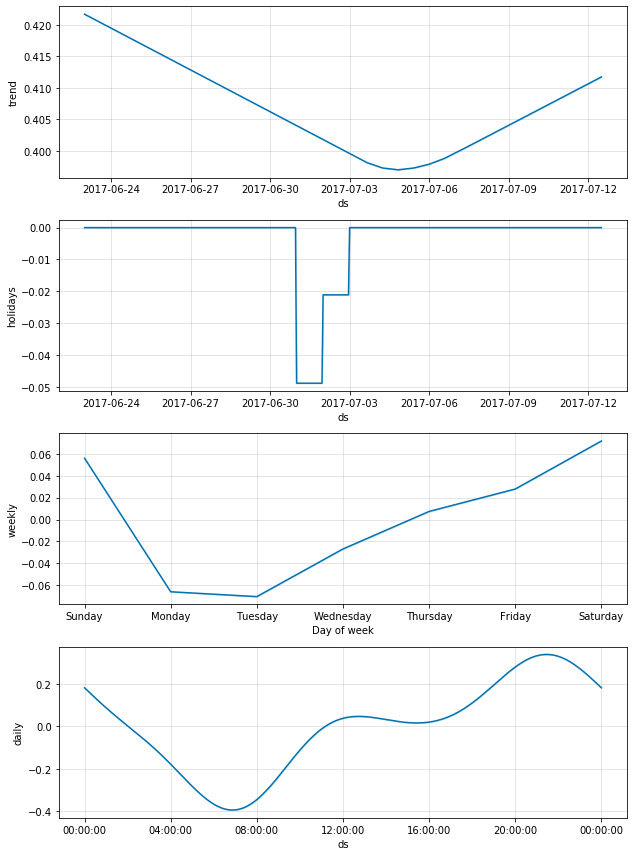

In [37]:
fig1 = c2g_filtered_model.plot_components(c2g_filtered_forecast)
plt.savefig('images/prophet/c2g_trend.png', bbox_inches='tight')
plt.show()

In [41]:
cv_filtered_results_c2g = Prophet_Diagnostics.cross_validation(c2g_filtered_model,horizon="12 hours", period="1 hour")
Prophet_Diagnostics.performance_metrics(cv_filtered_results_c2g,rolling_window=1)

INFO:fbprophet:Making 277 forecasts with cutoffs between 2017-06-30 00:00:00 and 2017-07-11 12:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,12:00:00,0.009766,0.098823,0.077209,0.451717,0.167394,0.729543


In [ ]:
Prophet_Diagnostics.cross_validation()